# Timo's attempts at an MNIST classifier
My goal here is twofold: 
 * try to simply copy-paste my pre-existing (DyNet-based) MNIST code and log minimal adaptations necessary
 * adapt the code to make it more torchy

In [1]:
import time
import random
import os
import struct
import numpy as np
import torch
import torch.nn as nn
import ipywidgets as widgets
import PIL.Image

In [2]:
import matplotlib.pyplot as plt
from collections import defaultdict
# we will often repeatedly use some code for plotting. We define this once to be re-used later.
def plot(plot_data):
    plt.figure("evolution over training iterations")
    for type in plot_data.keys():
       plt.plot(plot_data[type], label=type)
    plt.legend(loc='upper right')

In [6]:
# minimally adapted from https://gist.github.com/akesling/5358964
def read_mnist(dataset, path="data/MNIST/raw/"):
    if dataset == "training":
        fname_img = os.path.join(path, "train-images-idx3-ubyte")
        fname_lbl = os.path.join(path, "train-labels-idx1-ubyte")
    elif dataset == "testing":
        fname_img = os.path.join(path, "t10k-images-idx3-ubyte")
        fname_lbl = os.path.join(path, "t10k-labels-idx1-ubyte")
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, "rb") as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        labels = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, "rb") as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        images = np.multiply(
            np.fromfile(fimg, dtype=np.uint8).reshape(len(labels), rows*cols),
            1.0 / 255.0)

    get_instance = lambda idx: (labels[idx], images[idx])

    # Create an iterator which returns each image in turn
    for i in range(len(labels)):
        yield get_instance(i)
        
training = [(lbl, img) for (lbl, img) in read_mnist("training")]
testing = [(lbl, img) for (lbl, img) in read_mnist("testing")]

In [7]:
import io
# print some examples (pairs of target number and image)
for i in range(10):
    buffer = io.BytesIO()
    PIL.Image.fromarray((256*training[i][1]).reshape(28, 28)).convert('L').save(buffer, format="PNG")
    display(training[i][0], widgets.Image(value=buffer.getvalue(),width=28,height=28))

5

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

0

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

4

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

1

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

9

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

2

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

1

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

3

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

1

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

4

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

In [8]:
HIDDEN_DIM1 = 64
HIDDEN_DIM2 = 64
DROPOUT_RATE = 0.5

In [24]:
class MNISTClassify(nn.Module):
    def __init__(self):
        super(MNISTClassify, self).__init__()
        input_size = 28 * 28
        self.W1 = nn.Parameter(nn.init.xavier_uniform_(torch.empty(input_size, HIDDEN_DIM1)))
        self.b1 = nn.Parameter(nn.init.xavier_uniform_(torch.empty(1, HIDDEN_DIM1)))
        self.W2 = nn.Parameter(nn.init.xavier_uniform_(torch.empty(HIDDEN_DIM1, HIDDEN_DIM2)))
        self.b2 = nn.Parameter(nn.init.xavier_uniform_(torch.empty(1, HIDDEN_DIM2)))
        self.W3 = nn.Parameter(nn.init.xavier_uniform_(torch.empty(HIDDEN_DIM2, 10)))
        self.b3 = nn.Parameter(nn.init.xavier_uniform_(torch.empty(1, 10)))
        
    def forward(self, x, isTrain=False):
        # erste innere Schicht:
        h1 = nn.functional.sigmoid(x @ self.W1 + self.b1)
        # zweite innere Schicht:
        h2 = nn.functional.sigmoid(h1 @ self.W2 + self.b2)
        # Ergebnisschicht:
        activation = nn.functional.sigmoid(h2 @ self.W3 + self.b3, dim=1)
        return activation

In [25]:
class MNISTClassify(nn.Module):
    """probably a more torchy version, considerably easier than the DyNet version."""
    def __init__(self):
        super(MNISTClassify, self).__init__()
        input_size = 28 * 28
        self.l1 = nn.Linear(input_size, HIDDEN_DIM1)
        self.l2 = nn.Linear(HIDDEN_DIM1, HIDDEN_DIM2)
        self.l3 = nn.Linear(HIDDEN_DIM2, 10)

    def forward(self, x, isTrain=False):
        return nn.functional.log_softmax(self.l3(nn.functional.sigmoid(self.l2(nn.functional.sigmoid(self.l1(x))))))


In [26]:
import torch.nn.functional as F
class MNISTClassify(nn.Module):
    """works much better with CNNs.
    shamefully stolen/borrowed from https://github.com/mbjoseph/pytorch-mnist/blob/master/cnn-mnist.ipynb
    """
    def __init__(self):
        super(MNISTClassify, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 120)
        self.fc1_drop = nn.Dropout()
        self.fc2 = nn.Linear(120, 10)
        
    def forward(self, x, isTrain=False):
        x = x.reshape((1,1,28,28))
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1_drop(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(x)
        return x.view((10))
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Epoch 1 starting


/tmp/ipykernel_200020/245547631.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Held out accuracy 0.3697 (2020.0007965758605 instances/sec)
   T0    T1    T2    T3    T4    T5    T6    T7    T8    T9    
P0 959   8     14    8     2     9     23    10    19    11    
P1 0     0     0     0     0     0     0     0     0     0     
P2 0     0     0     0     0     0     0     0     0     0     
P3 0     0     0     0     0     0     0     0     0     0     
P4 2     11    12    4     957   9     17    3     25    44    
P5 0     0     0     0     0     0     0     0     0     0     
P6 0     0     0     0     0     0     0     0     0     0     
P7 0     0     0     0     0     0     2     0     0     0     
P8 13    1110  1004  988   16    851   913   998   882   55    
P9 6     6     2     10    7     23    3     17    48    899   
instances per sec: 197.01721691919752
Epoch 2 starting
Held out accuracy 0.4639 (2269.8473181024306 instances/sec)
   T0    T1    T2    T3    T4    T5    T6    T7    T8    T9    
P0 956   10    12    1     1     16    10    9     36    

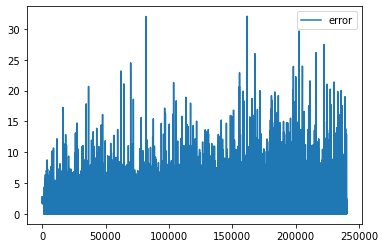

In [27]:
classify = MNISTClassify().float()
learning_rate = 0.01
#optimizer = torch.optim.SGD(classify.parameters(), lr = learning_rate)
optimizer = torch.optim.Adam(classify.parameters())
#loss = nn.CrossEntropyLoss
dev_time = 0
plot_data = defaultdict(lambda : [])

start = time.time()
for epoch in range(1,5):
    print(("Epoch {} starting".format(epoch)))
    random.shuffle(training)
    # train model:
    for cls, img in training:
        optimizer.zero_grad()
        # Bild als Eingabe aufbereiten
        x = torch.tensor(img).float()
        # Outputaktivierung berechnen
        output = classify(x, isTrain=True)
        # "idealen" Output (überall 0, nur gewählte Klasse ist 1)
        target = torch.zeros(10).long()
        target[cls] = 1.0
        # Kostenfunktion berechnen
        #loss = torch.sum((output - target) ** 2)
        loss  = nn.functional.nll_loss(output, torch.tensor(cls).long())
        # Kosten den einzelnen Parametern zuordnen
        plot_data["error"].append(loss.item())
        loss.backward()
        # Parameter entsprechend anpassen
        optimizer.step()

    # test performance of classifier:
    confusion = [[0 for _ in range(10)] for _ in range(10)]
    correct = 0
    dev_start = time.time()
    for cls, img in testing:
        optimizer.zero_grad()
        x = torch.tensor(img).float()
        output = classify(x, isTrain=False)
        prediction = int(torch.topk(output, 1)[1].item())
        if cls == prediction:
            correct += 1
        confusion[prediction][cls] += 1
    dev_end = time.time()
    acc = float(correct) / len(testing)
    dev_time += dev_end - dev_start
    print(("Held out accuracy {} ({} instances/sec)".format(
        acc, len(testing) / (dev_end - dev_start))))
    print('   ' + ''.join(('T'+str(x)).ljust(6) for x in range(10)))
    for p, row in enumerate(confusion):
        s = 'P' + str(p) + ' '
        s += ''.join(str(col).ljust(6) for col in row)
        print(s)

    end = time.time()
    print(("instances per sec: {}".format(
                (epoch * len(training)) / (end - start - dev_time))))

plot(plot_data)

Notes on differences between DyNet and PyTorch: 
* in DyNet, I register parameters without specifying the tensor that will be used for it; it will be automatically assigned.
    * In PyTorch, I register a specific tensor. Smart as I am, I didn't assign a zeros-tensor -- instead I have to ponder about parameter initialization.
    * It turns out that DyNet uses Glorot/Xavier initialization and some aspect of it depends on the following non-linearity. (wow!)
    * I'll (roughly) replace with what DyNet does → yields pretty much identical results
* instead of `*` for matrix multiplication, one has to write `@`. Okay.
* Something that I did not quite understand about float() and double() with tensors.
* DyNet is 5 times faster than PyTorch, wow! (I wonder what is causing this.)
    * it's not the manually defined loss function
    * it's not the use of parameters myself over using nn.Linear layers (which is still a little slower)

In [5]:
import dynet as dy
dy.sigmoid = dy.logistic

class MNISTClassify(object):
    def __init__(self, m):
        input_size = 28 * 28
        self.W1 = m.add_parameters((HIDDEN_DIM1, input_size))
        self.b1 = m.add_parameters((HIDDEN_DIM1, ))
        self.W2 = m.add_parameters((HIDDEN_DIM2, HIDDEN_DIM1))
        self.b2 = m.add_parameters((HIDDEN_DIM2, ))
        self.W3 = m.add_parameters((10, HIDDEN_DIM2))
        self.b3 = m.add_parameters((10, ))

    def __call__(self, x, isTrain=False):
        # erste innere Schicht:
        h1 = dy.sigmoid(self.W1 * x + self.b1)
        # zweite innere Schicht:
        h2 = dy.sigmoid(self.W2 * h1 + self.b2)
        # Ergebnisschicht:
        activation = dy.sigmoid(self.W3 * h2 + self.b3)
        return activation

m = dy.Model()
classify = MNISTClassify(m)
#sgd = dy.SimpleSGDTrainer(m, learning_rate=0.01)
sgd = dy.AdamTrainer(m)
dev_time = 0

start = time.time()
for epoch in range(1,5):
    random.shuffle(training)
    print(("Epoch {} starting".format(epoch)))
    # train model:
    for cls, img in training:
        dy.renew_cg()
        # Bild als Eingabe aufbereiten
        x = dy.inputVector(img)
        # Outputaktivierung berechnen
        output = classify(x, isTrain=True)
        # "idealen" Output (überall 0, nur gewählte Klasse ist 1)
        target = np.zeros(10)
        target[cls] = 1
        target = dy.inputVector(target)
        # Kostenfunktion berechnen
        loss = 0.5 * dy.sum_elems((output - target) ** 2)
        # Kosten den einzelnen Parametern zuordnen
        loss.backward()
        # Parameter entsprechend anpassen
        sgd.update()

    # test performance of classifier:
    confusion = [[0 for _ in range(10)] for _ in range(10)]
    correct = 0
    dev_start = time.time()
    for cls, img in testing:
        dy.renew_cg()
        x = dy.inputVector(img)
        output = classify(x, isTrain=False)
        prediction = max([(v,i) for (i,v) in enumerate(output.value())])[1]
        if cls == prediction:
            correct += 1
        confusion[prediction][cls] += 1
    dev_end = time.time()
    acc = float(correct) / len(testing)
    dev_time += dev_end - dev_start
    print(("Held out accuracy {} ({} instances/sec)".format(
        acc, len(testing) / (dev_end - dev_start))))
    print('   ' + ''.join(('T'+str(x)).ljust(6) for x in range(10)))
    for p, row in enumerate(confusion):
        s = 'P' + str(p) + ' '
        s += ''.join(str(col).ljust(6) for col in row)
        print(s)

    end = time.time()
    print(("instances per sec: {}".format(
                (epoch * len(training)) / (end - start - dev_time))))

[dynet] random seed: 1054449114
[dynet] allocating memory: 512MB
[dynet] memory allocation done.


Epoch 1 starting
Held out accuracy 0.95 (13516.539965002627 instances/sec)
   T0    T1    T2    T3    T4    T5    T6    T7    T8    T9    
P0 970   0     10    1     3     11    15    2     5     9     
P1 0     1114  2     0     0     0     3     7     1     6     
P2 2     4     990   15    3     2     1     13    5     1     
P3 1     3     4     947   0     18    1     2     13    7     
P4 0     0     3     1     946   1     2     1     3     42    
P5 3     1     0     10    0     825   6     1     7     14    
P6 1     5     6     0     8     7     922   0     7     0     
P7 2     2     9     15    7     3     1     1001  11    49    
P8 1     6     8     20    4     23    7     0     922   18    
P9 0     0     0     1     11    2     0     1     0     863   
instances per sec: 8257.331566533325
Epoch 2 starting
Held out accuracy 0.9621 (13458.776899558723 instances/sec)
   T0    T1    T2    T3    T4    T5    T6    T7    T8    T9    
P0 969   0     6     1     1     4     9   